# ResNet 계열에서 레이어 수가 성능에 미치는 영향 분석

본 실험은 ResNet 구조에서 레이어 수가 늘어날수록 모델의 성능이 유지되거나 향상되는지를 확인하고자 수행되었다.
ResNet-18, ResNet-50, ResNet-101의 세 가지 구조를 동일한 조건(CIFAR-10, 학습률, 배치 크기 등)하에서 학습한 후, 성능과 gradient 흐름을 비교 분석하였다.


## ResNet(Residual Network)

ResNet은 딥러닝 모델이 깊어질수록 발생하는 vanishing gradient 문제를 해결하기 위해 skip connection을 도입한 구조이다.
핵심 개념은 **잔차 학습(residual learning)**으로, 각 블록이 입력을 그대로 출력에 더해주는 방식으로 gradient가 더 깊은 계층까지 안정적으로 전달된다.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
import numpy as np

#Configuration 
CONFIG = {
    "model_name": "ResNet",
    "dataset_name": "CIFAR10",
    "num_classes": 10,
    "batch_size": 128,
    "epochs": 100,  
    "learning_rate": 0.1, 
    "momentum": 0.9,
    "weight_decay": 5e-4, 
    "gamma": 0.1, 
    "step_size": 30,
    "save_path": "./results/resnet_comparison.png",
    "device": torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"),
    "data_root": "./data"
}


In [ ]:

# --- Gradient Tracking Classes ---
class GradientTracker:
    def __init__(self):
        self.gradients = {}
        self.hooks = []
        self.module_names = {} # To store human-readable names for modules

    def register_hook(self, name, module):
        # Register a hook to capture gradients of the output (grad_output) of a module
        def hook_fn(module, grad_input, grad_output):
            if grad_output and grad_output[0] is not None:
                # Store the mean absolute gradient magnitude
                self.gradients[name] = grad_output[0].abs().mean().item()
            else:
                self.gradients[name] = 0.0
        self.hooks.append(module.register_backward_hook(hook_fn))
        self.module_names[module] = name # Store the name for the module

    def clear(self):
        self.gradients.clear()
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        self.module_names.clear()

# Global tracker instance
global_grad_tracker = GradientTracker()

# Global tracker instance
global_grad_tracker = GradientTracker()

In [ ]:
# --- ResNet Building Blocks ---
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(identity)
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += self.shortcut(identity)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Register hooks for the output of each major layer/block to track gradients
        global_grad_tracker.register_hook("conv1_output", self.bn1) # After initial conv+bn
        global_grad_tracker.register_hook("layer1_output", self.layer1)
        global_grad_tracker.register_hook("layer2_output", self.layer2)
        global_grad_tracker.register_hook("layer3_output", self.layer3)
        global_grad_tracker.register_hook("layer4_output", self.layer4)

        self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride_val in strides: # Renamed stride to stride_val to avoid conflict
            layers.append(block(self.in_channels, out_channels, stride_val))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01) # Changed from 0.01 to a smaller value for FC layers
                nn.init.constant_(m.bias, 0)


In [ ]:
# --- Model and Data Utility Functions ---
def get_model(name, num_classes):
    # Clear previous hooks before creating a new model to avoid conflicts
    global_grad_tracker.clear()

    if name == "ResNet18":
        return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
    elif name == "ResNet50":
        return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)
    elif name == "ResNet101":
        return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)
    else:
        raise ValueError(f"Unsupported model: {name}")

def get_dataloaders(dataset_name, root, batch_size):
    if dataset_name == "CIFAR10":
        # CIFAR-10 mean and std for normalization
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]

        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std), # Added normalization
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std), # Added normalization
        ])

        train_dataset = torchvision.datasets.CIFAR10(
            root=root, train=True, download=True, transform=transform_train
        )
        test_dataset = torchvision.datasets.CIFAR10(
            root=root, train=False, download=True, transform=transform_test
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() // 2 or 1) # Added num_workers
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count() // 2 or 1) # Added num_workers

        return train_loader, test_loader
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, train_loader, test_loader, device, epochs, lr, momentum, weight_decay, gamma, step_size):
    torch.autograd.set_detect_anomaly(True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # Using StepLR for learning rate scheduling
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    train_accs, test_accs = [], []
    gradient_history_per_epoch = [] # Store gradient snapshots per epoch

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'})

        # Capture gradients after an epoch (or a few batches)
        # For simplicity, we capture gradients after the entire training epoch
        # You might want to capture them more frequently (e.g., every N batches) for detailed analysis
        current_gradients = global_grad_tracker.gradients.copy()
        gradient_history_per_epoch.append(current_gradients)

        train_acc = evaluate(model, train_loader, device)
        test_acc = evaluate(model, test_loader, device)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
        scheduler.step() # Update learning rate

    training_time = time.time() - start_time
    return train_accs, test_accs, training_time, gradient_history_per_epoch

def plot_results(results, save_path, epochs_trained):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # Adjusted figure size

    # Plot accuracy comparison
    ax1 = axes[0, 0]
    for label, accs in results['test_accuracies'].items(): # Changed to test_accuracies directly
        ax1.plot(range(1, epochs_trained[label] + 1), accs, label=label) # Use actual epochs trained
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Test Accuracy")
    ax1.set_title("Test Accuracy Comparison Over Epochs")
    ax1.legend()
    ax1.grid(True)

    # Plot parameter count comparison
    ax2 = axes[0, 1]
    models = list(results['parameters'].keys())
    params = list(results['parameters'].values())
    ax2.bar(models, params, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax2.set_xlabel("Model")
    ax2.set_ylabel("Number of Parameters")
    ax2.set_title("Parameter Count Comparison")
    ax2.tick_params(axis='x', rotation=45)

    # Plot training time comparison
    ax3 = axes[1, 0]
    times = list(results['training_times'].values())
    ax3.bar(models, times, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax3.set_xlabel("Model")
    ax3.set_ylabel("Training Time (seconds)")
    ax3.set_title("Training Time Comparison")
    ax3.tick_params(axis='x', rotation=45)

    # Plot gradient flow (average over epochs)
    ax4 = axes[1, 1]
    # Filter out empty gradient lists
    filtered_gradient_flows = {k: v for k, v in results['gradient_flows'].items() if v}

    if filtered_gradient_flows:
        for model_name, gradients_per_epoch in filtered_gradient_flows.items():
            if not gradients_per_epoch: # Skip if no gradients were recorded
                continue

            # Average gradients over all epochs for each layer
            # Ensure all dictionaries have the same keys (layers) before averaging
            all_layer_names = sorted(list(set(key for grad_dict in gradients_per_epoch for key in grad_dict.keys())))

            avg_gradients_by_layer = {name: [] for name in all_layer_names}

            for grad_dict in gradients_per_epoch:
                for layer_name in all_layer_names:
                    avg_gradients_by_layer[layer_name].append(grad_dict.get(layer_name, 0.0)) # Use 0.0 if key missing

            # Take the mean across epochs for each layer
            final_avg_gradients = [np.mean(avg_gradients_by_layer[name]) for name in all_layer_names]

            ax4.plot(range(len(all_layer_names)), final_avg_gradients, label=model_name, marker='o', linestyle='--')

        ax4.set_xlabel("Layer Index (Approx. Depth)")
        ax4.set_ylabel("Average Gradient Magnitude")
        ax4.set_title("Average Gradient Magnitude Across Network Depth")
        ax4.set_xticks(range(len(all_layer_names)))
        ax4.set_xticklabels(all_layer_names, rotation=90, fontsize=8) # Rotate labels for readability
        ax4.legend()
        ax4.grid(True)
    else:
        ax4.text(0.5, 0.5, "No gradient data to plot.", horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)


    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()




Running: ResNet18


100%|██████████| 170M/170M [00:02<00:00, 62.9MB/s]


Number of parameters: 11,173,962


Epoch 1/100:   0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Epoch 1/100: 100%|██████████| 391/391 [00:23<00:00, 16.56it/s, loss=1.7813, lr=0.100000]


Epoch 1/100 | Train Acc: 0.3165 | Test Acc: 0.3279


Epoch 2/100: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s, loss=1.6133, lr=0.100000]


Epoch 2/100 | Train Acc: 0.4267 | Test Acc: 0.4463


Epoch 3/100: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s, loss=1.1505, lr=0.100000]


Epoch 3/100 | Train Acc: 0.5288 | Test Acc: 0.5296


Epoch 4/100: 100%|██████████| 391/391 [00:21<00:00, 18.02it/s, loss=0.9274, lr=0.100000]


Epoch 4/100 | Train Acc: 0.6413 | Test Acc: 0.6558


Epoch 5/100: 100%|██████████| 391/391 [00:21<00:00, 18.15it/s, loss=0.6710, lr=0.100000]


Epoch 5/100 | Train Acc: 0.6991 | Test Acc: 0.6968


Epoch 6/100: 100%|██████████| 391/391 [00:21<00:00, 18.22it/s, loss=0.9769, lr=0.100000]


Epoch 6/100 | Train Acc: 0.7281 | Test Acc: 0.7237


Epoch 7/100: 100%|██████████| 391/391 [00:21<00:00, 18.17it/s, loss=0.5395, lr=0.100000]


Epoch 7/100 | Train Acc: 0.7641 | Test Acc: 0.7626


Epoch 8/100: 100%|██████████| 391/391 [00:21<00:00, 17.92it/s, loss=0.5588, lr=0.100000]


Epoch 8/100 | Train Acc: 0.7469 | Test Acc: 0.7389


Epoch 9/100: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s, loss=0.5088, lr=0.100000]


Epoch 9/100 | Train Acc: 0.7914 | Test Acc: 0.7739


Epoch 10/100: 100%|██████████| 391/391 [00:21<00:00, 18.11it/s, loss=0.4089, lr=0.100000]


Epoch 10/100 | Train Acc: 0.6530 | Test Acc: 0.6355


Epoch 11/100: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s, loss=0.4480, lr=0.100000]


Epoch 11/100 | Train Acc: 0.7848 | Test Acc: 0.7844


Epoch 12/100: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s, loss=0.6507, lr=0.100000]


Epoch 12/100 | Train Acc: 0.7326 | Test Acc: 0.7207


Epoch 13/100: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s, loss=0.3733, lr=0.100000]


Epoch 13/100 | Train Acc: 0.7986 | Test Acc: 0.7818


Epoch 14/100: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s, loss=0.5230, lr=0.100000]


Epoch 14/100 | Train Acc: 0.8288 | Test Acc: 0.8147


Epoch 15/100: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s, loss=0.3967, lr=0.100000]


Epoch 15/100 | Train Acc: 0.8311 | Test Acc: 0.8170


Epoch 16/100: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s, loss=0.4578, lr=0.100000]


Epoch 16/100 | Train Acc: 0.8272 | Test Acc: 0.8116


Epoch 17/100: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s, loss=0.5453, lr=0.100000]


Epoch 17/100 | Train Acc: 0.8234 | Test Acc: 0.8152


Epoch 18/100: 100%|██████████| 391/391 [00:21<00:00, 18.17it/s, loss=0.4419, lr=0.100000]


Epoch 18/100 | Train Acc: 0.8376 | Test Acc: 0.8258


Epoch 19/100: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s, loss=0.6605, lr=0.100000]


Epoch 19/100 | Train Acc: 0.8606 | Test Acc: 0.8429


Epoch 20/100: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s, loss=0.4701, lr=0.100000]


Epoch 20/100 | Train Acc: 0.8078 | Test Acc: 0.7876


Epoch 21/100: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s, loss=0.4512, lr=0.100000]


Epoch 21/100 | Train Acc: 0.8349 | Test Acc: 0.8130


Epoch 22/100: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s, loss=0.2811, lr=0.100000]


Epoch 22/100 | Train Acc: 0.8071 | Test Acc: 0.7938


Epoch 23/100: 100%|██████████| 391/391 [00:21<00:00, 17.78it/s, loss=0.2452, lr=0.100000]


Epoch 23/100 | Train Acc: 0.8399 | Test Acc: 0.8213


Epoch 24/100: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s, loss=0.5998, lr=0.100000]


Epoch 24/100 | Train Acc: 0.8472 | Test Acc: 0.8257


Epoch 25/100: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s, loss=0.4494, lr=0.100000]


Epoch 25/100 | Train Acc: 0.8336 | Test Acc: 0.8243


Epoch 26/100: 100%|██████████| 391/391 [00:21<00:00, 18.18it/s, loss=0.4059, lr=0.100000]


Epoch 26/100 | Train Acc: 0.8381 | Test Acc: 0.8135


Epoch 27/100: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s, loss=0.3541, lr=0.100000]


Epoch 27/100 | Train Acc: 0.8219 | Test Acc: 0.7994


Epoch 28/100: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s, loss=0.4692, lr=0.100000]


Epoch 28/100 | Train Acc: 0.8693 | Test Acc: 0.8476


Epoch 29/100: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s, loss=0.4318, lr=0.100000]


Epoch 29/100 | Train Acc: 0.8357 | Test Acc: 0.8120


Epoch 30/100: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s, loss=0.3969, lr=0.100000]


Epoch 30/100 | Train Acc: 0.8680 | Test Acc: 0.8524


Epoch 31/100: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s, loss=0.3423, lr=0.010000]


Epoch 31/100 | Train Acc: 0.9503 | Test Acc: 0.9214


Epoch 32/100: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s, loss=0.0798, lr=0.010000]


Epoch 32/100 | Train Acc: 0.9605 | Test Acc: 0.9236


Epoch 33/100: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s, loss=0.0731, lr=0.010000]


Epoch 33/100 | Train Acc: 0.9653 | Test Acc: 0.9282


Epoch 34/100: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s, loss=0.0968, lr=0.010000]


Epoch 34/100 | Train Acc: 0.9685 | Test Acc: 0.9291


Epoch 35/100: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s, loss=0.0796, lr=0.010000]


Epoch 35/100 | Train Acc: 0.9723 | Test Acc: 0.9304


Epoch 36/100: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s, loss=0.0375, lr=0.010000]


Epoch 36/100 | Train Acc: 0.9756 | Test Acc: 0.9285


Epoch 37/100: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s, loss=0.1226, lr=0.010000]


Epoch 37/100 | Train Acc: 0.9772 | Test Acc: 0.9325


Epoch 38/100: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s, loss=0.0834, lr=0.010000]


Epoch 38/100 | Train Acc: 0.9821 | Test Acc: 0.9326


Epoch 39/100: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s, loss=0.1067, lr=0.010000]


Epoch 39/100 | Train Acc: 0.9806 | Test Acc: 0.9287


Epoch 40/100: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s, loss=0.1123, lr=0.010000]


Epoch 40/100 | Train Acc: 0.9820 | Test Acc: 0.9313


Epoch 41/100: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s, loss=0.0141, lr=0.010000]


Epoch 41/100 | Train Acc: 0.9827 | Test Acc: 0.9295


Epoch 42/100: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s, loss=0.0226, lr=0.010000]


Epoch 42/100 | Train Acc: 0.9849 | Test Acc: 0.9295


Epoch 43/100: 100%|██████████| 391/391 [00:21<00:00, 17.96it/s, loss=0.1559, lr=0.010000]


Epoch 43/100 | Train Acc: 0.9838 | Test Acc: 0.9299


Epoch 44/100: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s, loss=0.0176, lr=0.010000]


Epoch 44/100 | Train Acc: 0.9862 | Test Acc: 0.9292


Epoch 45/100: 100%|██████████| 391/391 [00:21<00:00, 17.99it/s, loss=0.0380, lr=0.010000]


Epoch 45/100 | Train Acc: 0.9851 | Test Acc: 0.9283


Epoch 46/100: 100%|██████████| 391/391 [00:21<00:00, 17.96it/s, loss=0.1004, lr=0.010000]


Epoch 46/100 | Train Acc: 0.9858 | Test Acc: 0.9310


Epoch 47/100: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s, loss=0.0840, lr=0.010000]


Epoch 47/100 | Train Acc: 0.9832 | Test Acc: 0.9277


Epoch 48/100: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s, loss=0.0881, lr=0.010000]


Epoch 48/100 | Train Acc: 0.9891 | Test Acc: 0.9294


Epoch 49/100: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s, loss=0.0705, lr=0.010000]


Epoch 49/100 | Train Acc: 0.9877 | Test Acc: 0.9289


Epoch 50/100: 100%|██████████| 391/391 [00:21<00:00, 18.13it/s, loss=0.0378, lr=0.010000]


Epoch 50/100 | Train Acc: 0.9886 | Test Acc: 0.9288


Epoch 51/100: 100%|██████████| 391/391 [00:21<00:00, 18.13it/s, loss=0.0910, lr=0.010000]


Epoch 51/100 | Train Acc: 0.9886 | Test Acc: 0.9325


Epoch 52/100: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s, loss=0.0874, lr=0.010000]


Epoch 52/100 | Train Acc: 0.9793 | Test Acc: 0.9184


Epoch 53/100: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s, loss=0.0225, lr=0.010000]


Epoch 53/100 | Train Acc: 0.9852 | Test Acc: 0.9249


Epoch 54/100: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s, loss=0.0344, lr=0.010000]


Epoch 54/100 | Train Acc: 0.9857 | Test Acc: 0.9236


Epoch 55/100: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s, loss=0.0961, lr=0.010000]


Epoch 55/100 | Train Acc: 0.9831 | Test Acc: 0.9213


Epoch 56/100: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s, loss=0.0777, lr=0.010000]


Epoch 56/100 | Train Acc: 0.9881 | Test Acc: 0.9305


Epoch 57/100: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s, loss=0.0680, lr=0.010000]


Epoch 57/100 | Train Acc: 0.9876 | Test Acc: 0.9256


Epoch 58/100: 100%|██████████| 391/391 [00:21<00:00, 18.02it/s, loss=0.0718, lr=0.010000]


Epoch 58/100 | Train Acc: 0.9870 | Test Acc: 0.9222


Epoch 59/100: 100%|██████████| 391/391 [00:21<00:00, 17.96it/s, loss=0.0663, lr=0.010000]


Epoch 59/100 | Train Acc: 0.9858 | Test Acc: 0.9235


Epoch 60/100: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s, loss=0.0618, lr=0.010000]


Epoch 60/100 | Train Acc: 0.9866 | Test Acc: 0.9264


Epoch 61/100: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s, loss=0.0128, lr=0.001000]


Epoch 61/100 | Train Acc: 0.9972 | Test Acc: 0.9386


Epoch 62/100: 100%|██████████| 391/391 [00:21<00:00, 17.99it/s, loss=0.0109, lr=0.001000]


Epoch 62/100 | Train Acc: 0.9978 | Test Acc: 0.9393


Epoch 63/100: 100%|██████████| 391/391 [00:21<00:00, 17.85it/s, loss=0.0271, lr=0.001000]


Epoch 63/100 | Train Acc: 0.9987 | Test Acc: 0.9401


Epoch 64/100: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s, loss=0.0123, lr=0.001000]


Epoch 64/100 | Train Acc: 0.9988 | Test Acc: 0.9414


Epoch 65/100: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s, loss=0.0081, lr=0.001000]


Epoch 65/100 | Train Acc: 0.9990 | Test Acc: 0.9411


Epoch 66/100: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s, loss=0.0051, lr=0.001000]


Epoch 66/100 | Train Acc: 0.9993 | Test Acc: 0.9417


Epoch 67/100: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s, loss=0.0247, lr=0.001000]


Epoch 67/100 | Train Acc: 0.9994 | Test Acc: 0.9421


Epoch 68/100: 100%|██████████| 391/391 [00:22<00:00, 17.65it/s, loss=0.0053, lr=0.001000]


Epoch 68/100 | Train Acc: 0.9995 | Test Acc: 0.9424


Epoch 69/100: 100%|██████████| 391/391 [00:22<00:00, 17.68it/s, loss=0.0094, lr=0.001000]


Epoch 69/100 | Train Acc: 0.9992 | Test Acc: 0.9422


Epoch 70/100: 100%|██████████| 391/391 [00:22<00:00, 17.55it/s, loss=0.0034, lr=0.001000]


Epoch 70/100 | Train Acc: 0.9993 | Test Acc: 0.9406


Epoch 71/100: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s, loss=0.0025, lr=0.001000]


Epoch 71/100 | Train Acc: 0.9995 | Test Acc: 0.9418


Epoch 72/100: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s, loss=0.0037, lr=0.001000]


Epoch 72/100 | Train Acc: 0.9994 | Test Acc: 0.9426


Epoch 73/100: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s, loss=0.0059, lr=0.001000]


Epoch 73/100 | Train Acc: 0.9996 | Test Acc: 0.9421


Epoch 74/100: 100%|██████████| 391/391 [00:22<00:00, 17.66it/s, loss=0.0152, lr=0.001000]


Epoch 74/100 | Train Acc: 0.9996 | Test Acc: 0.9431


Epoch 75/100: 100%|██████████| 391/391 [00:22<00:00, 17.52it/s, loss=0.0036, lr=0.001000]


Epoch 75/100 | Train Acc: 0.9996 | Test Acc: 0.9448


Epoch 76/100: 100%|██████████| 391/391 [00:22<00:00, 17.72it/s, loss=0.0053, lr=0.001000]


Epoch 76/100 | Train Acc: 0.9996 | Test Acc: 0.9444


Epoch 77/100: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s, loss=0.0019, lr=0.001000]


Epoch 77/100 | Train Acc: 0.9998 | Test Acc: 0.9435


Epoch 78/100: 100%|██████████| 391/391 [00:22<00:00, 17.65it/s, loss=0.0052, lr=0.001000]


Epoch 78/100 | Train Acc: 0.9998 | Test Acc: 0.9436


Epoch 79/100: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s, loss=0.0039, lr=0.001000]


Epoch 79/100 | Train Acc: 0.9996 | Test Acc: 0.9430


Epoch 80/100: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s, loss=0.0134, lr=0.001000]


Epoch 80/100 | Train Acc: 0.9997 | Test Acc: 0.9437


Epoch 81/100: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s, loss=0.0077, lr=0.001000]


Epoch 81/100 | Train Acc: 0.9996 | Test Acc: 0.9433


Epoch 82/100: 100%|██████████| 391/391 [00:22<00:00, 17.51it/s, loss=0.0074, lr=0.001000]


Epoch 82/100 | Train Acc: 0.9998 | Test Acc: 0.9448


Epoch 83/100: 100%|██████████| 391/391 [00:22<00:00, 17.41it/s, loss=0.0118, lr=0.001000]


Epoch 83/100 | Train Acc: 0.9997 | Test Acc: 0.9438


Epoch 84/100: 100%|██████████| 391/391 [00:22<00:00, 17.54it/s, loss=0.0019, lr=0.001000]


Epoch 84/100 | Train Acc: 0.9998 | Test Acc: 0.9447


Epoch 85/100: 100%|██████████| 391/391 [00:22<00:00, 17.70it/s, loss=0.0032, lr=0.001000]


Epoch 85/100 | Train Acc: 0.9998 | Test Acc: 0.9447


Epoch 86/100: 100%|██████████| 391/391 [00:22<00:00, 17.75it/s, loss=0.0027, lr=0.001000]


Epoch 86/100 | Train Acc: 0.9998 | Test Acc: 0.9451


Epoch 87/100: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s, loss=0.0069, lr=0.001000]


Epoch 87/100 | Train Acc: 0.9999 | Test Acc: 0.9437


Epoch 88/100: 100%|██████████| 391/391 [00:22<00:00, 17.60it/s, loss=0.0055, lr=0.001000]


Epoch 88/100 | Train Acc: 0.9998 | Test Acc: 0.9443


Epoch 89/100: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s, loss=0.0138, lr=0.001000]


Epoch 89/100 | Train Acc: 0.9999 | Test Acc: 0.9441


Epoch 90/100: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s, loss=0.0030, lr=0.001000]


Epoch 90/100 | Train Acc: 0.9998 | Test Acc: 0.9452


Epoch 91/100: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s, loss=0.0045, lr=0.000100]


Epoch 91/100 | Train Acc: 0.9999 | Test Acc: 0.9449


Epoch 92/100: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s, loss=0.0030, lr=0.000100]


Epoch 92/100 | Train Acc: 0.9999 | Test Acc: 0.9451


Epoch 93/100: 100%|██████████| 391/391 [00:22<00:00, 17.54it/s, loss=0.0035, lr=0.000100]


Epoch 93/100 | Train Acc: 0.9999 | Test Acc: 0.9446


Epoch 94/100: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s, loss=0.0087, lr=0.000100]


Epoch 94/100 | Train Acc: 0.9998 | Test Acc: 0.9445


Epoch 95/100: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s, loss=0.0021, lr=0.000100]


Epoch 95/100 | Train Acc: 0.9998 | Test Acc: 0.9449


Epoch 96/100: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s, loss=0.0019, lr=0.000100]


Epoch 96/100 | Train Acc: 0.9999 | Test Acc: 0.9447


Epoch 97/100: 100%|██████████| 391/391 [00:22<00:00, 17.64it/s, loss=0.0029, lr=0.000100]


Epoch 97/100 | Train Acc: 0.9999 | Test Acc: 0.9456


Epoch 98/100: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s, loss=0.0020, lr=0.000100]


Epoch 98/100 | Train Acc: 0.9999 | Test Acc: 0.9453


Epoch 99/100: 100%|██████████| 391/391 [00:22<00:00, 17.60it/s, loss=0.0094, lr=0.000100]


Epoch 99/100 | Train Acc: 0.9999 | Test Acc: 0.9446


Epoch 100/100: 100%|██████████| 391/391 [00:22<00:00, 17.66it/s, loss=0.0016, lr=0.000100]


Epoch 100/100 | Train Acc: 0.9999 | Test Acc: 0.9455
Training time for ResNet18: 2695.26 seconds

Running: ResNet50
Number of parameters: 23,520,842


Epoch 1/100: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s, loss=2.2523, lr=0.100000]


Epoch 1/100 | Train Acc: 0.1141 | Test Acc: 0.1104


Epoch 2/100: 100%|██████████| 391/391 [00:54<00:00,  7.24it/s, loss=2.0671, lr=0.100000]


Epoch 2/100 | Train Acc: 0.2353 | Test Acc: 0.2288


Epoch 3/100: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s, loss=1.9063, lr=0.100000]


Epoch 3/100 | Train Acc: 0.3121 | Test Acc: 0.3222


Epoch 4/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=1.5891, lr=0.100000]


Epoch 4/100 | Train Acc: 0.4042 | Test Acc: 0.4107


Epoch 5/100: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s, loss=1.5065, lr=0.100000]


Epoch 5/100 | Train Acc: 0.4779 | Test Acc: 0.4848


Epoch 6/100: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s, loss=1.1792, lr=0.100000]


Epoch 6/100 | Train Acc: 0.5277 | Test Acc: 0.5345


Epoch 7/100: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s, loss=0.9913, lr=0.100000]


Epoch 7/100 | Train Acc: 0.5908 | Test Acc: 0.5930


Epoch 8/100: 100%|██████████| 391/391 [00:53<00:00,  7.24it/s, loss=0.8740, lr=0.100000]


Epoch 8/100 | Train Acc: 0.6176 | Test Acc: 0.6219


Epoch 9/100: 100%|██████████| 391/391 [00:53<00:00,  7.27it/s, loss=0.8906, lr=0.100000]


Epoch 9/100 | Train Acc: 0.6725 | Test Acc: 0.6744


Epoch 10/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=0.8916, lr=0.100000]


Epoch 10/100 | Train Acc: 0.6417 | Test Acc: 0.6358


Epoch 11/100: 100%|██████████| 391/391 [00:53<00:00,  7.24it/s, loss=0.8596, lr=0.100000]


Epoch 11/100 | Train Acc: 0.6971 | Test Acc: 0.6800


Epoch 12/100: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s, loss=0.6748, lr=0.100000]


Epoch 12/100 | Train Acc: 0.6540 | Test Acc: 0.6416


Epoch 13/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=0.6144, lr=0.100000]


Epoch 13/100 | Train Acc: 0.6642 | Test Acc: 0.6594


Epoch 14/100: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s, loss=0.8209, lr=0.100000]


Epoch 14/100 | Train Acc: 0.7687 | Test Acc: 0.7561


Epoch 15/100: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s, loss=0.5995, lr=0.100000]


Epoch 15/100 | Train Acc: 0.7700 | Test Acc: 0.7603


Epoch 16/100: 100%|██████████| 391/391 [00:54<00:00,  7.23it/s, loss=0.5384, lr=0.100000]


Epoch 16/100 | Train Acc: 0.7561 | Test Acc: 0.7380


Epoch 17/100: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s, loss=0.9029, lr=0.100000]


Epoch 17/100 | Train Acc: 0.6020 | Test Acc: 0.5837


Epoch 18/100: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s, loss=0.6787, lr=0.100000]


Epoch 18/100 | Train Acc: 0.7608 | Test Acc: 0.7508


Epoch 19/100: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s, loss=0.6472, lr=0.100000]


Epoch 19/100 | Train Acc: 0.7323 | Test Acc: 0.7149


Epoch 20/100: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s, loss=0.6199, lr=0.100000]


Epoch 20/100 | Train Acc: 0.7116 | Test Acc: 0.6906


Epoch 21/100: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s, loss=0.7410, lr=0.100000]


Epoch 21/100 | Train Acc: 0.7892 | Test Acc: 0.7785


Epoch 22/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=0.6237, lr=0.100000]


Epoch 22/100 | Train Acc: 0.7453 | Test Acc: 0.7390


Epoch 23/100: 100%|██████████| 391/391 [00:54<00:00,  7.23it/s, loss=0.6525, lr=0.100000]


Epoch 23/100 | Train Acc: 0.7946 | Test Acc: 0.7664


Epoch 24/100: 100%|██████████| 391/391 [00:53<00:00,  7.27it/s, loss=0.3272, lr=0.100000]


Epoch 24/100 | Train Acc: 0.7664 | Test Acc: 0.7525


Epoch 25/100: 100%|██████████| 391/391 [00:53<00:00,  7.24it/s, loss=0.4676, lr=0.100000]


Epoch 25/100 | Train Acc: 0.7924 | Test Acc: 0.7892


Epoch 26/100: 100%|██████████| 391/391 [00:54<00:00,  7.23it/s, loss=0.4043, lr=0.100000]


Epoch 26/100 | Train Acc: 0.7969 | Test Acc: 0.7749


Epoch 27/100: 100%|██████████| 391/391 [00:53<00:00,  7.24it/s, loss=0.6022, lr=0.100000]


Epoch 27/100 | Train Acc: 0.7692 | Test Acc: 0.7551


Epoch 28/100: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s, loss=0.5092, lr=0.100000]


Epoch 28/100 | Train Acc: 0.7910 | Test Acc: 0.7857


Epoch 29/100: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s, loss=0.6231, lr=0.100000]


Epoch 29/100 | Train Acc: 0.8009 | Test Acc: 0.7894


Epoch 30/100: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s, loss=0.4398, lr=0.100000]


Epoch 30/100 | Train Acc: 0.8124 | Test Acc: 0.7961


Epoch 31/100: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s, loss=0.2886, lr=0.010000]


Epoch 31/100 | Train Acc: 0.9217 | Test Acc: 0.8978


Epoch 32/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=0.3605, lr=0.010000]


Epoch 32/100 | Train Acc: 0.9317 | Test Acc: 0.9029


Epoch 33/100: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s, loss=0.1601, lr=0.010000]


Epoch 33/100 | Train Acc: 0.9378 | Test Acc: 0.9079


Epoch 34/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=0.2375, lr=0.010000]


Epoch 34/100 | Train Acc: 0.9415 | Test Acc: 0.9089


Epoch 35/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=0.2267, lr=0.010000]


Epoch 35/100 | Train Acc: 0.9467 | Test Acc: 0.9095


Epoch 36/100: 100%|██████████| 391/391 [00:54<00:00,  7.24it/s, loss=0.3621, lr=0.010000]


Epoch 36/100 | Train Acc: 0.9505 | Test Acc: 0.9094


Epoch 37/100: 100%|██████████| 391/391 [00:53<00:00,  7.27it/s, loss=0.1015, lr=0.010000]


Epoch 37/100 | Train Acc: 0.9523 | Test Acc: 0.9133


Epoch 38/100: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, loss=0.1628, lr=0.010000]


Epoch 38/100 | Train Acc: 0.9549 | Test Acc: 0.9121


Epoch 39/100: 100%|██████████| 391/391 [00:54<00:00,  7.24it/s, loss=0.0965, lr=0.010000]


Epoch 39/100 | Train Acc: 0.9529 | Test Acc: 0.9082


Epoch 40/100: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s, loss=0.1163, lr=0.010000]


Epoch 40/100 | Train Acc: 0.9608 | Test Acc: 0.9131


Epoch 41/100: 100%|██████████| 391/391 [00:54<00:00,  7.23it/s, loss=0.0754, lr=0.010000]


Epoch 41/100 | Train Acc: 0.9577 | Test Acc: 0.9069


Epoch 42/100: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s, loss=0.2415, lr=0.010000]


Epoch 42/100 | Train Acc: 0.9579 | Test Acc: 0.9061


Epoch 43/100: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s, loss=0.1187, lr=0.010000]


Epoch 43/100 | Train Acc: 0.9636 | Test Acc: 0.9084


Epoch 44/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.1976, lr=0.010000]


Epoch 44/100 | Train Acc: 0.9641 | Test Acc: 0.9097


Epoch 45/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.1250, lr=0.010000]


Epoch 45/100 | Train Acc: 0.9658 | Test Acc: 0.9129


Epoch 46/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.1239, lr=0.010000]


Epoch 46/100 | Train Acc: 0.9569 | Test Acc: 0.9027


Epoch 47/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.1356, lr=0.010000]


Epoch 47/100 | Train Acc: 0.9684 | Test Acc: 0.9129


Epoch 48/100: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s, loss=0.0661, lr=0.010000]


Epoch 48/100 | Train Acc: 0.9653 | Test Acc: 0.9082


Epoch 49/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.0384, lr=0.010000]


Epoch 49/100 | Train Acc: 0.9679 | Test Acc: 0.9075


Epoch 50/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.0773, lr=0.010000]


Epoch 50/100 | Train Acc: 0.9696 | Test Acc: 0.9066


Epoch 51/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.0801, lr=0.010000]


Epoch 51/100 | Train Acc: 0.9676 | Test Acc: 0.9062


Epoch 52/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.1039, lr=0.010000]


Epoch 52/100 | Train Acc: 0.9632 | Test Acc: 0.9012


Epoch 53/100: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s, loss=0.0696, lr=0.010000]


Epoch 53/100 | Train Acc: 0.9647 | Test Acc: 0.9032


Epoch 54/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.1506, lr=0.010000]


Epoch 54/100 | Train Acc: 0.9681 | Test Acc: 0.9062


Epoch 55/100: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s, loss=0.1757, lr=0.010000]


Epoch 55/100 | Train Acc: 0.9626 | Test Acc: 0.8976


Epoch 56/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.1924, lr=0.010000]


Epoch 56/100 | Train Acc: 0.9642 | Test Acc: 0.9024


Epoch 57/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.0889, lr=0.010000]


Epoch 57/100 | Train Acc: 0.9719 | Test Acc: 0.9114


Epoch 58/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.2376, lr=0.010000]


Epoch 58/100 | Train Acc: 0.9631 | Test Acc: 0.9025


Epoch 59/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0472, lr=0.010000]


Epoch 59/100 | Train Acc: 0.9710 | Test Acc: 0.9108


Epoch 60/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.1058, lr=0.010000]


Epoch 60/100 | Train Acc: 0.9645 | Test Acc: 0.9081


Epoch 61/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.0282, lr=0.001000]


Epoch 61/100 | Train Acc: 0.9914 | Test Acc: 0.9280


Epoch 62/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0514, lr=0.001000]


Epoch 62/100 | Train Acc: 0.9934 | Test Acc: 0.9315


Epoch 63/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0183, lr=0.001000]


Epoch 63/100 | Train Acc: 0.9957 | Test Acc: 0.9298


Epoch 64/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0299, lr=0.001000]


Epoch 64/100 | Train Acc: 0.9962 | Test Acc: 0.9317


Epoch 65/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0178, lr=0.001000]


Epoch 65/100 | Train Acc: 0.9964 | Test Acc: 0.9333


Epoch 66/100: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s, loss=0.0296, lr=0.001000]


Epoch 66/100 | Train Acc: 0.9967 | Test Acc: 0.9317


Epoch 67/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.0216, lr=0.001000]


Epoch 67/100 | Train Acc: 0.9975 | Test Acc: 0.9322


Epoch 68/100: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s, loss=0.0098, lr=0.001000]


Epoch 68/100 | Train Acc: 0.9976 | Test Acc: 0.9333


Epoch 69/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0204, lr=0.001000]


Epoch 69/100 | Train Acc: 0.9977 | Test Acc: 0.9330


Epoch 70/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0122, lr=0.001000]


Epoch 70/100 | Train Acc: 0.9982 | Test Acc: 0.9330


Epoch 71/100: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s, loss=0.0074, lr=0.001000]


Epoch 71/100 | Train Acc: 0.9980 | Test Acc: 0.9315


Epoch 72/100: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s, loss=0.0094, lr=0.001000]


Epoch 72/100 | Train Acc: 0.9981 | Test Acc: 0.9333


Epoch 73/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0026, lr=0.001000]


Epoch 73/100 | Train Acc: 0.9983 | Test Acc: 0.9331


Epoch 74/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0029, lr=0.001000]


Epoch 74/100 | Train Acc: 0.9984 | Test Acc: 0.9336


Epoch 75/100: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s, loss=0.0431, lr=0.001000]


Epoch 75/100 | Train Acc: 0.9986 | Test Acc: 0.9355


Epoch 76/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0068, lr=0.001000]


Epoch 76/100 | Train Acc: 0.9991 | Test Acc: 0.9353


Epoch 77/100: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s, loss=0.0081, lr=0.001000]


Epoch 77/100 | Train Acc: 0.9989 | Test Acc: 0.9350


Epoch 78/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0096, lr=0.001000]


Epoch 78/100 | Train Acc: 0.9990 | Test Acc: 0.9350


Epoch 79/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.0020, lr=0.001000]


Epoch 79/100 | Train Acc: 0.9992 | Test Acc: 0.9363


Epoch 80/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0075, lr=0.001000]


Epoch 80/100 | Train Acc: 0.9992 | Test Acc: 0.9354


Epoch 81/100: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s, loss=0.0046, lr=0.001000]


Epoch 81/100 | Train Acc: 0.9992 | Test Acc: 0.9357


Epoch 82/100: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s, loss=0.0028, lr=0.001000]


Epoch 82/100 | Train Acc: 0.9990 | Test Acc: 0.9333


Epoch 83/100: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s, loss=0.0229, lr=0.001000]


Epoch 83/100 | Train Acc: 0.9994 | Test Acc: 0.9360


Epoch 84/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0119, lr=0.001000]


Epoch 84/100 | Train Acc: 0.9992 | Test Acc: 0.9365


Epoch 85/100: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s, loss=0.0035, lr=0.001000]


Epoch 85/100 | Train Acc: 0.9991 | Test Acc: 0.9331


Epoch 86/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0113, lr=0.001000]


Epoch 86/100 | Train Acc: 0.9995 | Test Acc: 0.9352


Epoch 87/100: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s, loss=0.0025, lr=0.001000]


Epoch 87/100 | Train Acc: 0.9993 | Test Acc: 0.9329


Epoch 88/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0210, lr=0.001000]


Epoch 88/100 | Train Acc: 0.9996 | Test Acc: 0.9349


Epoch 89/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0039, lr=0.001000]


Epoch 89/100 | Train Acc: 0.9995 | Test Acc: 0.9339


Epoch 90/100: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s, loss=0.0079, lr=0.001000]


Epoch 90/100 | Train Acc: 0.9995 | Test Acc: 0.9340


Epoch 91/100: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s, loss=0.0300, lr=0.000100]


Epoch 91/100 | Train Acc: 0.9997 | Test Acc: 0.9332


Epoch 92/100: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s, loss=0.0028, lr=0.000100]


Epoch 92/100 | Train Acc: 0.9995 | Test Acc: 0.9349


Epoch 93/100: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s, loss=0.0182, lr=0.000100]


Epoch 93/100 | Train Acc: 0.9996 | Test Acc: 0.9342


Epoch 94/100: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s, loss=0.0110, lr=0.000100]


Epoch 94/100 | Train Acc: 0.9995 | Test Acc: 0.9338


Epoch 95/100: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s, loss=0.0029, lr=0.000100]


Epoch 95/100 | Train Acc: 0.9997 | Test Acc: 0.9346


Epoch 96/100: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s, loss=0.0016, lr=0.000100]


Epoch 96/100 | Train Acc: 0.9995 | Test Acc: 0.9347


Epoch 97/100: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s, loss=0.0251, lr=0.000100]


Epoch 97/100 | Train Acc: 0.9996 | Test Acc: 0.9346


Epoch 98/100: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s, loss=0.0034, lr=0.000100]


Epoch 98/100 | Train Acc: 0.9994 | Test Acc: 0.9354


Epoch 99/100: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s, loss=0.0023, lr=0.000100]


Epoch 99/100 | Train Acc: 0.9996 | Test Acc: 0.9338


Epoch 100/100: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s, loss=0.0022, lr=0.000100]


Epoch 100/100 | Train Acc: 0.9995 | Test Acc: 0.9346
Training time for ResNet50: 6349.18 seconds

Running: ResNet101
Number of parameters: 42,512,970


Epoch 1/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=2.0671, lr=0.100000]


Epoch 1/100 | Train Acc: 0.2199 | Test Acc: 0.2161


Epoch 2/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=1.7859, lr=0.100000]


Epoch 2/100 | Train Acc: 0.2565 | Test Acc: 0.2650


Epoch 3/100: 100%|██████████| 391/391 [01:37<00:00,  4.01it/s, loss=1.8143, lr=0.100000]


Epoch 3/100 | Train Acc: 0.3178 | Test Acc: 0.3268


Epoch 4/100: 100%|██████████| 391/391 [01:38<00:00,  3.97it/s, loss=1.4915, lr=0.100000]


Epoch 4/100 | Train Acc: 0.4184 | Test Acc: 0.4173


Epoch 5/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=1.5152, lr=0.100000]


Epoch 5/100 | Train Acc: 0.4851 | Test Acc: 0.4992


Epoch 6/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=1.2345, lr=0.100000]


Epoch 6/100 | Train Acc: 0.5728 | Test Acc: 0.5738


Epoch 7/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.9170, lr=0.100000]


Epoch 7/100 | Train Acc: 0.5218 | Test Acc: 0.5264


Epoch 8/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.7502, lr=0.100000]


Epoch 8/100 | Train Acc: 0.6215 | Test Acc: 0.6241


Epoch 9/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.8977, lr=0.100000]


Epoch 9/100 | Train Acc: 0.7199 | Test Acc: 0.7193


Epoch 10/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.9279, lr=0.100000]


Epoch 10/100 | Train Acc: 0.7302 | Test Acc: 0.7298


Epoch 11/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.7613, lr=0.100000]


Epoch 11/100 | Train Acc: 0.7248 | Test Acc: 0.7135


Epoch 12/100: 100%|██████████| 391/391 [01:37<00:00,  4.01it/s, loss=0.7286, lr=0.100000]


Epoch 12/100 | Train Acc: 0.7294 | Test Acc: 0.7072


Epoch 13/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.5794, lr=0.100000]


Epoch 13/100 | Train Acc: 0.7379 | Test Acc: 0.7299


Epoch 14/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.7382, lr=0.100000]


Epoch 14/100 | Train Acc: 0.7477 | Test Acc: 0.7402


Epoch 15/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.5906, lr=0.100000]


Epoch 15/100 | Train Acc: 0.7629 | Test Acc: 0.7533


Epoch 16/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.5992, lr=0.100000]


Epoch 16/100 | Train Acc: 0.7917 | Test Acc: 0.7768


Epoch 17/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.4250, lr=0.100000]


Epoch 17/100 | Train Acc: 0.8027 | Test Acc: 0.7955


Epoch 18/100: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s, loss=0.5087, lr=0.100000]


Epoch 18/100 | Train Acc: 0.7932 | Test Acc: 0.7749


Epoch 19/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.6011, lr=0.100000]


Epoch 19/100 | Train Acc: 0.7836 | Test Acc: 0.7703


Epoch 20/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.5041, lr=0.100000]


Epoch 20/100 | Train Acc: 0.7853 | Test Acc: 0.7805


Epoch 21/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.4406, lr=0.100000]


Epoch 21/100 | Train Acc: 0.8229 | Test Acc: 0.8053


Epoch 22/100: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s, loss=0.7218, lr=0.100000]


Epoch 22/100 | Train Acc: 0.7796 | Test Acc: 0.7635


Epoch 23/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.4631, lr=0.100000]


Epoch 23/100 | Train Acc: 0.7930 | Test Acc: 0.7764


Epoch 24/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.4286, lr=0.100000]


Epoch 24/100 | Train Acc: 0.7814 | Test Acc: 0.7700


Epoch 25/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.3771, lr=0.100000]


Epoch 25/100 | Train Acc: 0.7702 | Test Acc: 0.7518


Epoch 26/100: 100%|██████████| 391/391 [01:36<00:00,  4.05it/s, loss=0.3908, lr=0.100000]


Epoch 26/100 | Train Acc: 0.8146 | Test Acc: 0.8035


Epoch 27/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.3605, lr=0.100000]


Epoch 27/100 | Train Acc: 0.8412 | Test Acc: 0.8270


Epoch 28/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.4198, lr=0.100000]


Epoch 28/100 | Train Acc: 0.8008 | Test Acc: 0.7843


Epoch 29/100: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s, loss=0.4481, lr=0.100000]


Epoch 29/100 | Train Acc: 0.7868 | Test Acc: 0.7787


Epoch 30/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.5414, lr=0.100000]


Epoch 30/100 | Train Acc: 0.8118 | Test Acc: 0.7996


Epoch 31/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.2887, lr=0.010000]


Epoch 31/100 | Train Acc: 0.9271 | Test Acc: 0.9019


Epoch 32/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.1282, lr=0.010000]


Epoch 32/100 | Train Acc: 0.9349 | Test Acc: 0.9077


Epoch 33/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.2530, lr=0.010000]


Epoch 33/100 | Train Acc: 0.9453 | Test Acc: 0.9100


Epoch 34/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.1994, lr=0.010000]


Epoch 34/100 | Train Acc: 0.9466 | Test Acc: 0.9091


Epoch 35/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.1615, lr=0.010000]


Epoch 35/100 | Train Acc: 0.9535 | Test Acc: 0.9135


Epoch 36/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.1999, lr=0.010000]


Epoch 36/100 | Train Acc: 0.9579 | Test Acc: 0.9174


Epoch 37/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.1647, lr=0.010000]


Epoch 37/100 | Train Acc: 0.9615 | Test Acc: 0.9152


Epoch 38/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.1908, lr=0.010000]


Epoch 38/100 | Train Acc: 0.9579 | Test Acc: 0.9120


Epoch 39/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.3353, lr=0.010000]


Epoch 39/100 | Train Acc: 0.9635 | Test Acc: 0.9129


Epoch 40/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.1861, lr=0.010000]


Epoch 40/100 | Train Acc: 0.9678 | Test Acc: 0.9159


Epoch 41/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.0934, lr=0.010000]


Epoch 41/100 | Train Acc: 0.9678 | Test Acc: 0.9196


Epoch 42/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.1355, lr=0.010000]


Epoch 42/100 | Train Acc: 0.9714 | Test Acc: 0.9176


Epoch 43/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.1914, lr=0.010000]


Epoch 43/100 | Train Acc: 0.9647 | Test Acc: 0.9125


Epoch 44/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.1168, lr=0.010000]


Epoch 44/100 | Train Acc: 0.9731 | Test Acc: 0.9145


Epoch 45/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.1110, lr=0.010000]


Epoch 45/100 | Train Acc: 0.9700 | Test Acc: 0.9136


Epoch 46/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.0391, lr=0.010000]


Epoch 46/100 | Train Acc: 0.9726 | Test Acc: 0.9165


Epoch 47/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.0856, lr=0.010000]


Epoch 47/100 | Train Acc: 0.9716 | Test Acc: 0.9133


Epoch 48/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.1475, lr=0.010000]


Epoch 48/100 | Train Acc: 0.9739 | Test Acc: 0.9172


Epoch 49/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.0894, lr=0.010000]


Epoch 49/100 | Train Acc: 0.9738 | Test Acc: 0.9086


Epoch 50/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.0974, lr=0.010000]


Epoch 50/100 | Train Acc: 0.9741 | Test Acc: 0.9150


Epoch 51/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.1184, lr=0.010000]


Epoch 51/100 | Train Acc: 0.9731 | Test Acc: 0.9124


Epoch 52/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.0916, lr=0.010000]


Epoch 52/100 | Train Acc: 0.9736 | Test Acc: 0.9133


Epoch 53/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.1193, lr=0.010000]


Epoch 53/100 | Train Acc: 0.9716 | Test Acc: 0.9098


Epoch 54/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.0487, lr=0.010000]


Epoch 54/100 | Train Acc: 0.9603 | Test Acc: 0.9009


Epoch 55/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.0800, lr=0.010000]


Epoch 55/100 | Train Acc: 0.9753 | Test Acc: 0.9150


Epoch 56/100: 100%|██████████| 391/391 [01:36<00:00,  4.05it/s, loss=0.0849, lr=0.010000]


Epoch 56/100 | Train Acc: 0.9738 | Test Acc: 0.9116


Epoch 57/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.1083, lr=0.010000]


Epoch 57/100 | Train Acc: 0.9768 | Test Acc: 0.9094


Epoch 58/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.1088, lr=0.010000]


Epoch 58/100 | Train Acc: 0.9773 | Test Acc: 0.9111


Epoch 59/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.2209, lr=0.010000]


Epoch 59/100 | Train Acc: 0.9736 | Test Acc: 0.9085


Epoch 60/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.0788, lr=0.010000]


Epoch 60/100 | Train Acc: 0.9713 | Test Acc: 0.9049


Epoch 61/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.0704, lr=0.001000]


Epoch 61/100 | Train Acc: 0.9939 | Test Acc: 0.9301


Epoch 62/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.0433, lr=0.001000]


Epoch 62/100 | Train Acc: 0.9954 | Test Acc: 0.9314


Epoch 63/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.0276, lr=0.001000]


Epoch 63/100 | Train Acc: 0.9968 | Test Acc: 0.9330


Epoch 64/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.0158, lr=0.001000]


Epoch 64/100 | Train Acc: 0.9977 | Test Acc: 0.9339


Epoch 65/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.0094, lr=0.001000]


Epoch 65/100 | Train Acc: 0.9978 | Test Acc: 0.9341


Epoch 66/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.0058, lr=0.001000]


Epoch 66/100 | Train Acc: 0.9980 | Test Acc: 0.9333


Epoch 67/100: 100%|██████████| 391/391 [01:37<00:00,  4.02it/s, loss=0.0076, lr=0.001000]


Epoch 67/100 | Train Acc: 0.9983 | Test Acc: 0.9349


Epoch 68/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.0188, lr=0.001000]


Epoch 68/100 | Train Acc: 0.9985 | Test Acc: 0.9333


Epoch 69/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.0036, lr=0.001000]


Epoch 69/100 | Train Acc: 0.9986 | Test Acc: 0.9337


Epoch 70/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.0066, lr=0.001000]


Epoch 70/100 | Train Acc: 0.9989 | Test Acc: 0.9346


Epoch 71/100: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, loss=0.0294, lr=0.001000]


Epoch 71/100 | Train Acc: 0.9987 | Test Acc: 0.9346


Epoch 72/100: 100%|██████████| 391/391 [01:36<00:00,  4.04it/s, loss=0.0308, lr=0.001000]


Epoch 72/100 | Train Acc: 0.9990 | Test Acc: 0.9360


Epoch 73/100: 100%|██████████| 391/391 [01:36<00:00,  4.03it/s, loss=0.0164, lr=0.001000]


Epoch 73/100 | Train Acc: 0.9990 | Test Acc: 0.9336


Epoch 74/100: 100%|██████████| 391/391 [01:36<00:00,  4.05it/s, loss=0.0110, lr=0.001000]


Epoch 74/100 | Train Acc: 0.9992 | Test Acc: 0.9350


Epoch 75/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0159, lr=0.001000]


Epoch 75/100 | Train Acc: 0.9992 | Test Acc: 0.9349


Epoch 76/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0024, lr=0.001000]


Epoch 76/100 | Train Acc: 0.9991 | Test Acc: 0.9349


Epoch 77/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0097, lr=0.001000]


Epoch 77/100 | Train Acc: 0.9994 | Test Acc: 0.9346


Epoch 78/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0026, lr=0.001000]


Epoch 78/100 | Train Acc: 0.9994 | Test Acc: 0.9334


Epoch 79/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0397, lr=0.001000]


Epoch 79/100 | Train Acc: 0.9995 | Test Acc: 0.9343


Epoch 80/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0026, lr=0.001000]


Epoch 80/100 | Train Acc: 0.9995 | Test Acc: 0.9344


Epoch 81/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0009, lr=0.001000]


Epoch 81/100 | Train Acc: 0.9993 | Test Acc: 0.9344


Epoch 82/100: 100%|██████████| 391/391 [01:35<00:00,  4.08it/s, loss=0.0058, lr=0.001000]


Epoch 82/100 | Train Acc: 0.9994 | Test Acc: 0.9342


Epoch 83/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0006, lr=0.001000]


Epoch 83/100 | Train Acc: 0.9995 | Test Acc: 0.9376


Epoch 84/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0031, lr=0.001000]


Epoch 84/100 | Train Acc: 0.9995 | Test Acc: 0.9353


Epoch 85/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0194, lr=0.001000]


Epoch 85/100 | Train Acc: 0.9996 | Test Acc: 0.9360


Epoch 86/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0118, lr=0.001000]


Epoch 86/100 | Train Acc: 0.9996 | Test Acc: 0.9347


Epoch 87/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0039, lr=0.001000]


Epoch 87/100 | Train Acc: 0.9995 | Test Acc: 0.9362


Epoch 88/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0035, lr=0.001000]


Epoch 88/100 | Train Acc: 0.9996 | Test Acc: 0.9346


Epoch 89/100: 100%|██████████| 391/391 [01:35<00:00,  4.08it/s, loss=0.0031, lr=0.001000]


Epoch 89/100 | Train Acc: 0.9997 | Test Acc: 0.9347


Epoch 90/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0072, lr=0.001000]


Epoch 90/100 | Train Acc: 0.9996 | Test Acc: 0.9340


Epoch 91/100: 100%|██████████| 391/391 [01:35<00:00,  4.08it/s, loss=0.0020, lr=0.000100]


Epoch 91/100 | Train Acc: 0.9998 | Test Acc: 0.9350


Epoch 92/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0009, lr=0.000100]


Epoch 92/100 | Train Acc: 0.9997 | Test Acc: 0.9347


Epoch 93/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0053, lr=0.000100]


Epoch 93/100 | Train Acc: 0.9997 | Test Acc: 0.9342


Epoch 94/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0064, lr=0.000100]


Epoch 94/100 | Train Acc: 0.9997 | Test Acc: 0.9355


Epoch 95/100: 100%|██████████| 391/391 [01:35<00:00,  4.09it/s, loss=0.0067, lr=0.000100]


Epoch 95/100 | Train Acc: 0.9998 | Test Acc: 0.9354


Epoch 96/100: 100%|██████████| 391/391 [01:35<00:00,  4.08it/s, loss=0.0062, lr=0.000100]


Epoch 96/100 | Train Acc: 0.9998 | Test Acc: 0.9352


Epoch 97/100: 100%|██████████| 391/391 [01:35<00:00,  4.08it/s, loss=0.0212, lr=0.000100]


Epoch 97/100 | Train Acc: 0.9997 | Test Acc: 0.9369


Epoch 98/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0018, lr=0.000100]


Epoch 98/100 | Train Acc: 0.9999 | Test Acc: 0.9347


Epoch 99/100: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s, loss=0.0220, lr=0.000100]


Epoch 99/100 | Train Acc: 0.9997 | Test Acc: 0.9351


Epoch 100/100: 100%|██████████| 391/391 [01:35<00:00,  4.10it/s, loss=0.0044, lr=0.000100]


Epoch 100/100 | Train Acc: 0.9999 | Test Acc: 0.9352
Training time for ResNet101: 11003.96 seconds


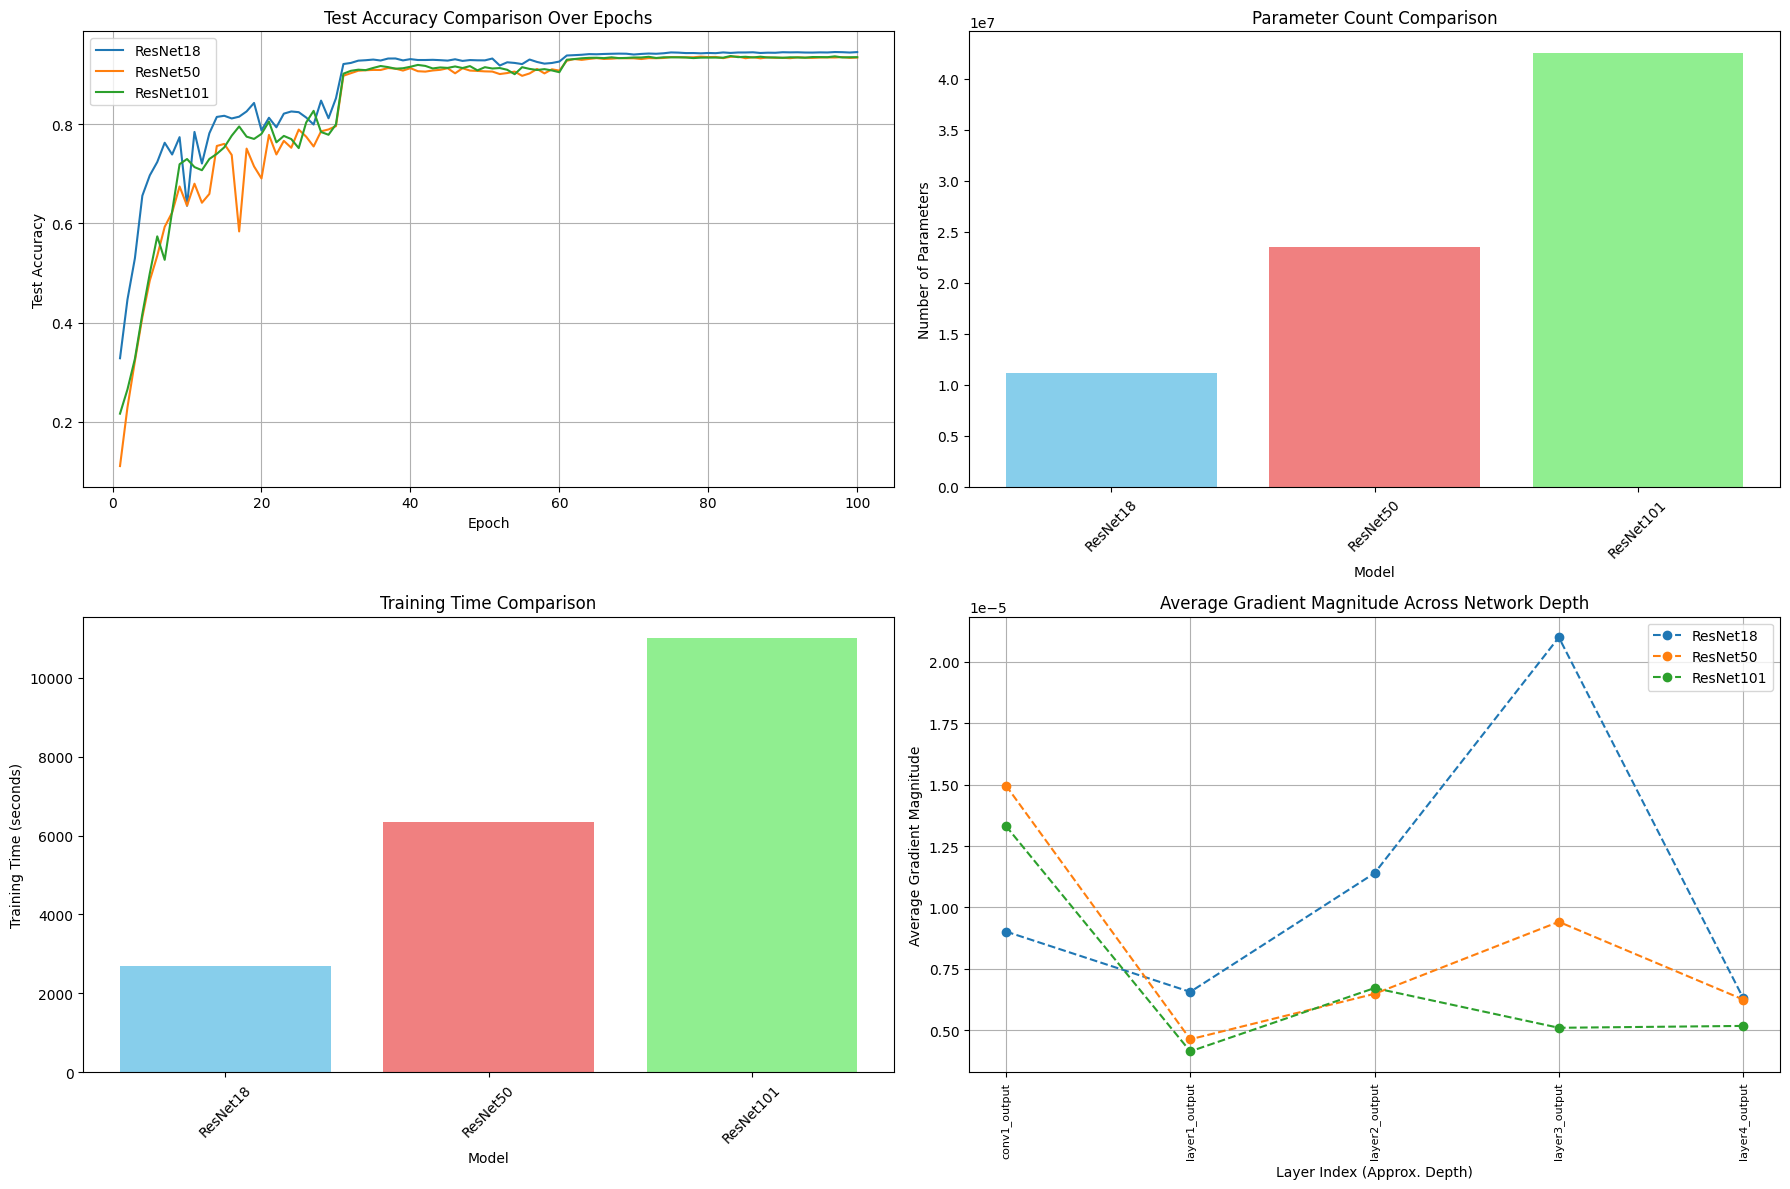

In [ ]:
def run_experiment(config):
    all_results = {
        'test_accuracies': {}, # Store list of test accuracies per epoch
        'parameters': {},
        'training_times': {},
        'gradient_flows': {} # Store gradient history per model
    }
    epochs_trained = {} # To track how many epochs each model actually ran for plotting

    # Clear global tracker at the start of the experiment
    global_grad_tracker.clear()

    for model_name in ["ResNet18", "ResNet50", "ResNet101"]:
        print(f"\nRunning: {model_name}")

        train_loader, test_loader = get_dataloaders(
            config["dataset_name"], config["data_root"], config["batch_size"]
        )

        model = get_model(model_name, config["num_classes"]).to(config["device"])

        num_params = count_parameters(model)
        all_results['parameters'][model_name] = num_params
        print(f"Number of parameters: {num_params:,}")

        # Train model
        train_acc_history, test_acc_history, training_time, gradient_history_for_model = train(
            model, train_loader, test_loader,
            config["device"], config["epochs"], config["learning_rate"],
            config["momentum"], config["weight_decay"], config["gamma"], config["step_size"]
        )

        all_results['test_accuracies'][model_name] = test_acc_history
        all_results['training_times'][model_name] = training_time
        all_results['gradient_flows'][model_name] = gradient_history_for_model
        epochs_trained[model_name] = len(test_acc_history) # Record actual epochs run

        print(f"Training time for {model_name}: {training_time:.2f} seconds")

    plot_results(all_results, config["save_path"], epochs_trained)

if __name__ == "__main__":
    run_experiment(CONFIG)

## 실험 요약 표

| **모델** | **최종 정확도 (%)** | **파라미터 수** | **총 학습 시간 (초)** |
| --- | --- | --- | --- |
| ResNet-18 | 94.56 | 약 11M | 약 2800초 |
| ResNet-50 | 93.54 | 약 25M | 약 6400초 |
| ResNet-101 | 93.69 | 약 44M | 약 11000초 |

### 성능 비교

- ResNet-18이 오히려 가장 높은 성능을 기록하였다. 
- ResNet-50과 101은 정확도에서 소폭 낮은 결과를 보였다. 하지만 3 모델 모두 90프로가 넘는 성능을 달성하였다.
- 레이어가 깊어짐에도 성능이 하락하지 않고 유지되는 모습이다.

![resnet_comparison](./figs/resnet_comparison.png)

### 모델 파라미터 수 비교 

- 모델의 깊이에 비례하여 파라미터 수는 2배, 4배 이상 증가하였다.
- 그러나 성능 향상은 이에 비례하지 않았으며, 특히 ResNet-101은 ResNet-18보다 약 4배 많은 파라미터를 사용하고도 성능은 오히려 낮거나 유사하다.
- 이는 성능 대비 연산 자원 낭비 가능성을 보여준다.

### 학습 시간 비교
- 깊이에 따라 학습 시간도 선형 혹은 그 이상으로 증가하였다.
- ResNet-101은 ResNet-18 대비 약 4배 더 긴 학습 시간이 소요되었지만, 정확도에서는 오히려 밀리는 결과를 보였다.

### Gradient 흐름 분석
- 모든 모델에서 초기 계층(conv1)에서는 비교적 높은 gradient가 나타났으며, 이후 깊은 계층으로 갈수록 gradient가 감소하는 경향을 보인다.
- ResNet-18은 전체적으로 gradient 크기 분포가 높고, 중간 계층에서도 gradient가 살아 있는 구조를 보임.
- ResNet-50 및 101은 deeper layer에서 gradient가 더 희박하게 나타났으며, 특히 layer4 영역에서는 세 모델 모두 유의미한 감소가 확인되었다.
- 이는 skip connection이 gradient 흐름을 돕기는 하나, 네트워크가 깊어질수록 residual path의 attenuation도 일부 존재함을 시사한다.

## 결론

본 실험은 ResNet 계열 구조(ResNet-18, ResNet-50, ResNet-101)를 대상으로 깊이 변화에 따른 분류 성능, 파라미터 수, 학습 시간, 그리고 gradient 흐름을 비교 분석하였다. 실험 결과는 다음과 같은 핵심적인 결론을 도출한다.

1. 성능 유지의 견고함

ResNet-18부터 ResNet-101까지 세 모델 모두 CIFAR-10에서 93~94%의 높은 정확도를 기록하였으며, 이는 네트워크 깊이가 증가하더라도 성능이 하락하지 않고 안정적으로 유지된다는 구조적 강인성을 보여준다.

2. Residual 구조의 효과성

Gradient 흐름 분석 결과, 세 모델 모두 전 계층에 걸쳐 평균 gradient가 일정 수준으로 유지되었으며, vanishing gradient 현상이 뚜렷하게 나타나지 않았다. 이는 skip connection이 학습의 안정성을 유지하고 깊은 구조에서도 효과적인 학습을 가능하게 한다는 것을 실증적으로 입증한다.

3. 확장 가능성과 효율성의 Trade-off

ResNet-101은 ResNet-18에 비해 약 4배의 파라미터 수와 3~4배 이상의 학습 시간을 요구했음에도 불구하고 성능 향상은 거의 없었다. 따라서, 실제 응용에서는 정확도 유지와 연산 효율성 간 균형을 고려한 구조 선택이 중요하며, ResNet-18은 가장 효율적인 선택지로 볼 수 있다.
